In [1]:
#Nessesary libs
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from tensorflow.keras.applications import EfficientNetV2B0

target_shape = (200, 200)

2023-08-26 13:14:58.453700: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-26 13:14:59.202248: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-26 13:14:59.202307: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-26 13:14:59.202312: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
cache_dir = Path(Path.home()) / ".keras"
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"
cache_dir

PosixPath('/home/bartlomiej/.keras')

In [3]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
!gdown 1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
!unzip -oq left.zip -d $cache_dir
!unzip -oq right.zip -d $cache_dir

Downloading...
From (uriginal): https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
From (redirected): https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34&confirm=t&uuid=bc1aae62-0549-4887-be4b-bed8d3931306
To: /home/bartlomiej/PycharmProjects/pythonProject/left.zip
100%|████████████████████████████████████████| 104M/104M [00:04<00:00, 21.9MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
From (redirected): https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW&confirm=t&uuid=994df3de-aaf5-4d66-8bb4-549136998ca5
To: /home/bartlomiej/PycharmProjects/pythonProject/right.zip
100%|████████████████████████████████████████| 104M/104M [00:02<00:00, 46.1MB/s]


In [4]:
def preprocess_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_pair(pair, label):
    return ((
        preprocess_image(pair[0]),
        preprocess_image(pair[1]),
    ),label)

In [5]:
anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)

positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

image_count = len(anchor_images)


anchors = anchor_images * 3
negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)
labels  = tf.constant([1]*6016 + [0]*12032)

comps = positive_images + negative_images

#input_imgs = tf.stack([img_1, img_2], axis=0)
dataset = tf.data.Dataset.from_tensor_slices(((anchors, comps), labels))
dataset = dataset.shuffle(buffer_size=20000)
dataset = dataset.map(preprocess_pair)
image_count*=3
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(8, drop_remainder=False)
# train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(8, drop_remainder=False)
# val_dataset = val_dataset.prefetch(8)

2023-08-26 13:16:43.026466: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-26 13:16:43.040198: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-26 13:16:43.040312: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-26 13:16:43.041129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [6]:

import matplotlib.pyplot as plt
ex = next(dataset.batch(60).as_numpy_iterator())
# ex = next(dataset.random(60).as_numpy_iterator())

[0 1 0 0 1]


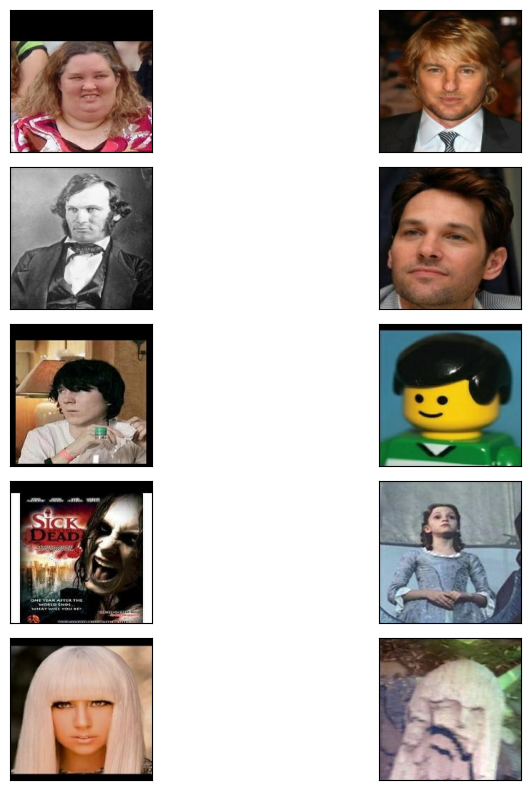

In [7]:
ex0 = ex[0][0]
ex1 = ex[0][1]

print(ex[1][:5])
fig, axes = plt.subplots(5, 2, figsize=(10, 8))
# Iterate through subplots and display images
for i, ax in enumerate(axes):
    ax[0].imshow(ex0[i])
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    ax[1].imshow(ex1[i])
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)
plt.tight_layout()
# plt.show()

# Architektura

In [19]:
from keras.layers import Dense, Concatenate, Reshape, Input, Conv2D, ReLU, BatchNormalization, GlobalAveragePooling2D
from keras.applications import EfficientNetV2B3
from keras.utils import plot_model
transfer_layer_size = 1000

base_cnn = EfficientNetV2B3(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)
# for layer in base_cnn.layers:
#     layer.trainable = False
flatten = layers.Flatten()(base_cnn.output)
# dense1 = layers.Dense(1024, activation="relu")(flatten)
# dense1 = layers.BatchNormalization()(dense1)
# dense2 = layers.Dense(1024, activation="relu")(dense1)
# dense2 = layers.BatchNormalization()(dense2)
# output = layers.Dense(transfer_layer_size)(dense2)
output = layers.Dense(transfer_layer_size, activation='relu')(flatten)


embedding = Model(inputs = base_cnn.input, outputs = output, name="Embedding")
# embedding.summary()
# plot_model(embedding, 'model.png')


img_input_1 = Input(target_shape + (3,), name="input_image_1")
img_input_2 = Input(target_shape + (3,), name="input_image_2")

feature_vector_A = embedding(img_input_1)
feature_vector_B = embedding(img_input_2)

joint_vector = Concatenate()([feature_vector_A, feature_vector_B])
siamese_dense_1 = Dense(transfer_layer_size*2, activation='relu', name='siamese_dense_1')(joint_vector)

base_density = 50

siamese_dense_2 = Dense(base_density*2*4*2, activation='relu', name='siamese_dense_2')(siamese_dense_1)
siamese_dense_3 = Dense(base_density*2*4, activation='relu', name='siamese_dense_3')(siamese_dense_2)
siamese_dense_4 = Dense(base_density*2, activation='relu', name='siamese_dense_4')(siamese_dense_3)
siamese_dense_5 = Dense(base_density, activation='relu', name='siamese_dense_5')(siamese_dense_4)
siamese_output = Dense(1, activation='sigmoid', name='siamese_output')(siamese_dense_5)

model = Model(inputs = [img_input_1, img_input_2], outputs = siamese_output)
# model.summary()
# plot_model(model, 'syjam.png')

# FIT

In [20]:
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy','mean_squared_error']) # 0.001 -> 0.001 binary_crossentropy ->mean_absolute_error
from keras.callbacks import EarlyStopping
es = EarlyStopping(patience=3)

In [21]:
def loss_fn(output, expected_output):
    return 1
def train_data_selection(train_data, _model):
    ratio = 0.4
    model_output = []
    for dp in train_data:
        model_output = _model.evaluate(dp[0])
    data_loss = [loss_fn(model_out, dp[1]) for (model_out, dp) in zip(model_output, train_data)]

    # posortować dataset po data_loss, nastepnie wziąc subset wynoszący ratio całego zbioru



In [22]:
model.fit(train_dataset, epochs=40, validation_data=val_dataset, callbacks=[es])

Epoch 1/40


2023-07-05 13:49:06.870128: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/Embedding/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1805/1805 [==============================] - 381s 192ms/step - loss: 0.2221 - accuracy: 0.6657 - mean_squared_error: 0.2221 - val_loss: 0.1989 - val_accuracy: 0.6856 - val_mean_squared_error: 0.1989
Epoch 2/40
1805/1805 [==============================] - 373s 206ms/step - loss: 0.2003 - accuracy: 0.6788 - mean_squared_error: 0.2003 - val_loss: 0.1756 - val_accuracy: 0.7402 - val_mean_squared_error: 0.1756
Epoch 3/40
1805/1805 [==============================] - 405s 224ms/step - loss: 0.1833 - accuracy: 0.7144 - mean_squared_error: 0.1833 - val_loss: 0.1634 - val_accuracy: 0.7524 - val_mean_squared_error: 0.1634
Epoch 4/40
1805/1805 [==============================] - 377s 209ms/step - loss: 0.1723 - accuracy: 0.7383 - mean_squared_error: 0.1723 - val_loss: 0.1512 - val_accuracy: 0.7806 - val_mean_squared_error: 0.1512
Epoch 5/40
1805/1805 [==============================] - 382s 211ms/step - loss: 0.1590 - accuracy: 0.7654 - mean_squared_error: 0.1590 - val_loss: 0.1428 - val_accuracy: 0

In [23]:
#for layer in embedding.layers:
 #   layer.trainable = True

In [24]:
# train_dataset
# for dp in train_dataset:
#     # print(dp[0][1][0][0].shape)
#     o = model.evaluate([dp[0][0], dp[0][1]])
#     # print("expected: " + dp[1][0] + ", got: " + o)
#     # print(o)

1/1 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - mean_squared_error: 0.0000e+00


In [26]:
model.save('dense90pacc.keras')

In [8]:
import tensorflow as tf

model = tf.keras.models.load_model('./dense90pacc.keras')

2023-08-26 13:17:41.774848: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 301056000 exceeds 10% of free system memory.
2023-08-26 13:17:43.238923: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 301056000 exceeds 10% of free system memory.
2023-08-26 13:17:44.051755: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 301056000 exceeds 10% of free system memory.


In [9]:
data = next(val_dataset.batch(1).as_numpy_iterator())

img1 = np.array([data[0][0][0][0]])
img2 = np.array([data[0][1][0][0]])

In [15]:
print(data[1][0][0])

1


In [10]:
model.predict([img1, img2])

2023-08-26 13:17:58.030394: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2023-08-26 13:17:58.297822: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 3s 3s/step


array([[0.98999876]], dtype=float32)

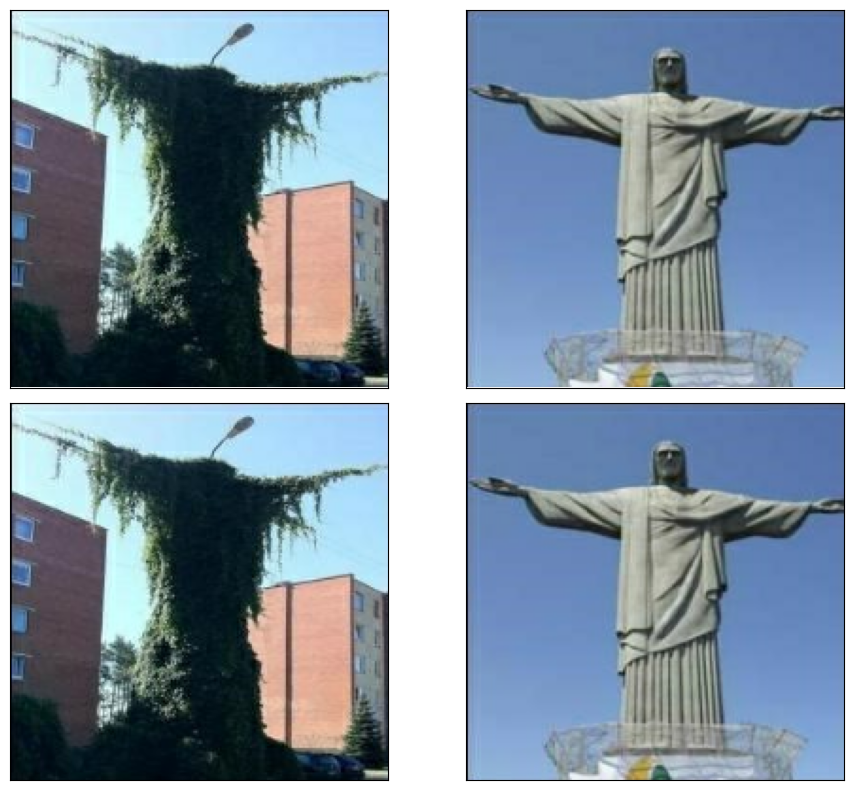

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
# Iterate through subplots and display images
for i, ax in enumerate(axes):
    ax[0].imshow(img1[0])
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    ax[1].imshow(img2[0])
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)
plt.tight_layout()
# plt.show()

In [17]:
# Accuracy (Dokładność):
# Procent poprawnych predykcji w stosunku do całkowitej liczby predykcji.
# $Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$
# Precision (Precyzja):
# Procent poprawnych pozytywnych predykcji w stosunku do wszystkich pozytywnych predykcji.
# $Precision = \frac{TP}{TP + FP}$
# Recall (Czułość):
# Procent poprawnych pozytywnych predykcji w stosunku do wszystkich rzeczywiście pozytywnych przypadków.
# $Recall = \frac{TP}{TP + FN}$
# F1-Score:
# Harmoniczna średnia precyzji i czułości.
# $F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$
total = 0
true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0
positive = 0
negative = 0
for i in range(len(val_dataset)):
    data = next(val_dataset.batch(1).as_numpy_iterator())
    for k in range(8):
        img1 = np.array([data[0][0][0][k]])
        img2 = np.array([data[0][1][0][k]])
        sim = data[1][0][k]
        pred = model.predict([img1, img2])[0]
        if sim == 0:
            negative+=1
            if pred > 0.5:
                false_negative += 1
            else:
                true_negative +=1
        if sim == 1:
            positive+=1
            if pred > 0.5:
                true_positive += 1
            else:
                false_positive +=1

1/1 [==============================] - 0s 23ms/step


In [18]:
print('true_positive', true_positive)
print('false_positive', false_positive)
print('true_negative',true_negative)
print('false_negative',false_negative)
print('positive',positive)
print('negative',negative)

true_positive 1040
false_positive 179
true_negative 2189
false_negative 208
positive 1219
negative 2397


In [19]:
accuracy = (true_positive + true_negative)/(positive+negative)
precision = true_positive/(true_positive+false_positive)
recall = true_positive/(true_positive + false_negative)
f1 = 2 * (precision * recall)/(precision+recall)
print('accuracy', accuracy)
print('precision', precision)
print('recall', recall)
print('f1-score', f1)

accuracy 0.8929756637168141
precision 0.8531583264971287
recall 0.8333333333333334
f1-score 0.8431293068504256
